In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import catboost 
from sklearn import metrics
from sklearn import model_selection

## Цель работы

В данной работе проведем оценку потенциального экономического эффекта от внедрения полученного решения. Для этого построим простую экономическую модель для оценки эффекта от внедрения нашей модели.

#### Импортируем данные

In [2]:
data = pd.read_csv('orange_small_churn_train_data.csv')


labels = data['labels']
data.drop(labels.index[-1], axis = 0, inplace = True)
labels = data['labels']
labels = np.array(list(map(lambda x: int(x) if x is not np.nan else x, labels)))


print(data.shape)
print('доля объектов класса отток: %.4f' % (data[data.labels == 1].labels.shape[0] / data.shape[0]))
print('доля объектов класса не отток: %.4f' % (data[data.labels != 1].labels.shape[0] / data.shape[0]))

(18298, 232)
доля объектов класса отток: 0.0753
доля объектов класса не отток: 0.9247


#### Разделим данные на обучение и тест

In [3]:
(data_train, data_test, 
 y_train, y_test) = model_selection.train_test_split(data, labels, 
                                                    test_size = 0.20, 
                                                    stratify = labels,
                                                    random_state = 1)


print('data_train size: {}'.format(data_train.shape))
print('labels_train size: {}'.format(y_train.shape))
print('')
print('data_test size: {}'.format(data_test.shape))
print('labels_test size: {}'.format(y_test.shape))

data_train size: (14638, 232)
labels_train size: (14638,)

data_test size: (3660, 232)
labels_test size: (3660,)


---

По итогам прошлых недель была построена **финальная модель** для классификации объектов. Модель состоит из следующих этапов:

**Преобразования данных:**
 - **Удаление** константных признаков и категориальных признаков, вариация значений которых больше 300.
 - **Заполнение** пропусков:
    - средними значениями у вещественных признаков
    - константными значениями у категориальных признаков
 - **Отбор** признаков на основе **корреляции** с целевой функцией:
    -  для вещественных признаков корреляция рассчитывается как разность математический ожиданий признака при условии класса "отток" и признака при условии класса "не отток".
    - для категориальных признаков корреляция рассчитывается с помощью коэффициента V крамера.
    
**Построение модели:**
 - В качестве модели используется модель градиентного бустинга (**catboost**).
 - Отдельно задаем, в качестве параметра модели, балансировку весов, на основе доли каждого класса в выборке. 
 - На вход модели подаются 10 вещественных и 25 категориальных признаков, которые имеют наибольшее значение корреляции с целевой функцией.

Все этапы построения модели перенесены в .py модули для уменьшения кода в текушем ноутбуке.

Модуль **Preprocessing** включает в себя разделение преобразование данных.
<br>
Модуль **FeaturesSelection** включает в себя отбор признаков на основе корреляции.
<br>
Модуль **Validation** нужен для оценки качества модели на кросс-валидации.
<br>
Модуль **Model** содержит в себе модель классификации.

Импортируем соответсвующие модули и классы, необходимые для построения модели.

In [4]:
from Preprocessing import FeaturesBorder, PreprocessingForCatboost
from FeaturesSelection import Correlation
from Validation import CrossValidation
from Model import Classifier

Функция для построения модели или оценки ее качества на кросс-валидации:

In [5]:
def building_model(data, data_train, y_train, data_test, y_test, cross_val = False):
    
    # separation features
    feature_border = FeaturesBorder(data)
    num_features = feature_border.choice_features(1, 191)
    cat_features = feature_border.choice_features(191, 231, num = False)

    # correlation
    data_num_correlation = Correlation(data).numeric_correlation(num_features)
    num_features_corr = list(data_num_correlation.abs().sort_values(by = 'correlation', 
                                                           ascending = False).index.to_numpy())

    data_cat_correlation = Correlation(data).categorical_correlation(cat_features)
    cat_features_corr = list(data_cat_correlation.sort_values(by = 'correlation', 
                                                           ascending = False).index.to_numpy())

    # preprocessing data
    preprocessing_catboost = PreprocessingForCatboost(num_features_corr[:10], cat_features_corr[:25])
    data_train_for_catboost = preprocessing_catboost.fit_transform(data_train)
    data_test_for_catboost = preprocessing_catboost.transform(data_test)
    
    # model
    classifier = Classifier(cat_features_corr[:25], data_test_for_catboost, y_test)

    # cross-validation
    if cross_val is not False:
        roc_auc_score_catboost = CrossValidation().cross_validation_for_catboost(classifier,
                                                       PreprocessingForCatboost(num_features_corr[:10], cat_features_corr[:25]),
                                                       data_train, y_train,
                                                       metrics = metrics.roc_auc_score)
        return roc_auc_score_catboost
    
    # model train
    classifier.fit(data_train_for_catboost, y_train)
    return data_train_for_catboost, data_test_for_catboost, classifier

Обучим модель:

In [6]:
data_train_catboost, data_test_catboost, model = building_model(data, data_train, y_train, data_test, y_test)

Определим порог для отнесения объектов к классу "отток". Для этого построим кривые точности и полноты в зависимости от порога.

Будем подбирать порог так, чтобы максимизировать полноту, но при этом не сильно снизить точность. Так как при уменьшении точности получим экономически невыгодную модель из-за большого количества трат на удержание пользователей, которые не собираются покидать организацию.

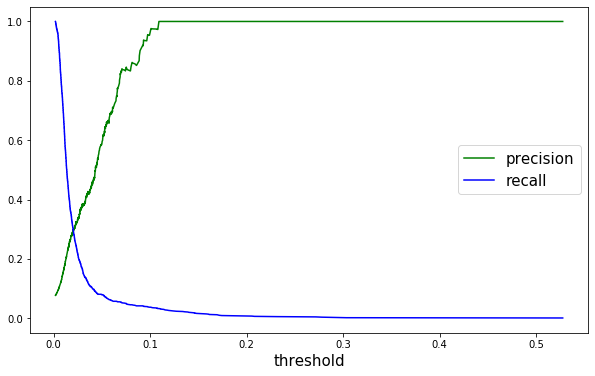

In [7]:
precision, recall, thresholds = metrics.precision_recall_curve(y_train, model.predict_proba(data_train_catboost)[:, 1])

plt.figure(figsize = (10, 6))
plt.plot(thresholds, precision[:-1], 
         color = 'green', label = 'precision')
plt.plot(thresholds, recall[:-1], color = 'blue', label = 'recall')
plt.xlabel('threshold', fontsize = 15)
plt.legend(prop = {'size': 15})
plt.show()

In [139]:
optimal_threshold = None
flag = 10
current_precision = 0.2
while flag > 0:
    flag = 0
    for i, value in enumerate(recall):
        if value < 0.3:
            break
        if precision[i] > current_precision:
            optimal_threshold = thresholds[i]
            flag += 1
    current_precision += 0.01

In [140]:
print('оптимальное значение threshold на данном этапе: {}'.format(optimal_threshold))

оптимальное значение threshold на данном этапе: 0.020175392232858743


##  Экономическая модель

Введем следующие параметры:
- денег в среднем приносит один пользователь: **5 условных единиц**. 
- денег в среднем будет вложено в удержание одного пользователя: **2 условные единицы**.
- вероятность принятия пользователем предложения по удержанию: **0.75**
- количесво пользователей, которые будут участвовать в кампании по удержанию: **изменяется**

Далее будем считать, что без примения модели все пользователи класса "отток" покинут организацию. 

С применением модели пользователи будут вести себя следующим образом:
- Верно отнесенные к классу "отток" останутся в компании с вероятностью 0.75
- Пользователи, на которых модель совершила ошибку false negative, т е совершила ложный пропуск пользователей с истинным классом "отток", покидают организацию.
- Пользователи, истинно отнесенные к классу "не отток", а также пользователи, ложно отнесенные к классу "отток" при их истинном классе "не отток" остаются в организации.

In [154]:
# доход без использования модели
income_without_model = sum(y_train != 1) * 5 


# доход с использованием модели
def income_with_model(low, hight, income_one_user = 5, retention_costs = 2, probability_contract = 0.7):
    income = []
    for current_thresholds in thresholds[low:hight]:
        predict = []
        for probability in model.predict_proba(data_train_catboost)[:, 1]:
            if probability >= current_thresholds:
                predict.append(1)
            else:
                predict.append(-1)
        
        true_positive = 0
        false_positive = 0 
        false_negative = 0
        true_negative = 0
        
        for i, value in enumerate(np.array(predict)):
            if value == 1 and y_train[i] == 1:
                true_positive += 1
            if value == 1 and y_train[i] == -1:
                false_positive += 1
            if value == -1 and y_train[i] == 1:
                false_negative += 1
            if value == -1 and y_train[i] == -1:
                true_negative += 1
        
        data_churn = pd.DataFrame(columns = ['Отток', 'Не отток'], 
                                  index = ['a(x) = 1', 'a(x) = -1'],
                                  data = [[true_positive, false_positive], 
                                          [false_negative, true_negative]])
        
        income.append((data_churn.iloc[1, 1] + data_churn.iloc[0, 1]) * income_one_user \
             + data_churn.iloc[0, 0] * probability_contract * income_one_user \
             - data_churn.iloc[0, 0] * retention_costs \
             - data_churn.iloc[0, 1] * retention_costs)
        
    return income

In [90]:
print('Доход без использования модели:  {} условных единиц'.format(income_without_model))
print('Доход с использованием модели и предварительно выбранным thresholds:  {} условных единиц'.format(
                                                                                        income_with_model(13242, 13243)[0]))

Доход без использования модели:  67680 условных единиц
Доход с использованием модели и предварительно выбранным thresholds:  66582.5 условных единиц


In [96]:
(67680 - 66582.5) / 66582.5 * 100

1.6483310179101114

In [125]:
(67680 - 66582.5)

1097.5

Доход без использования модели оказался больше, чем доход с использованием модели на 1.65 %. Если внедрить такую модель, то в итоге будут убытки в размере 1097.5 условных единиц.
<br>
Для модели был заранее подобран порог разделения для отнесения объектов к классу "отток". Данный порог был подобран исходя из построенных кривых точности и полноты и небольших прикидок для прибольности экономического эффекта. 


Попробуем перебирать пороги и смотреть на полученный доход. Для наглядности построим графики.

In [ ]:
income = income_with_model(9000, thresholds.shape)

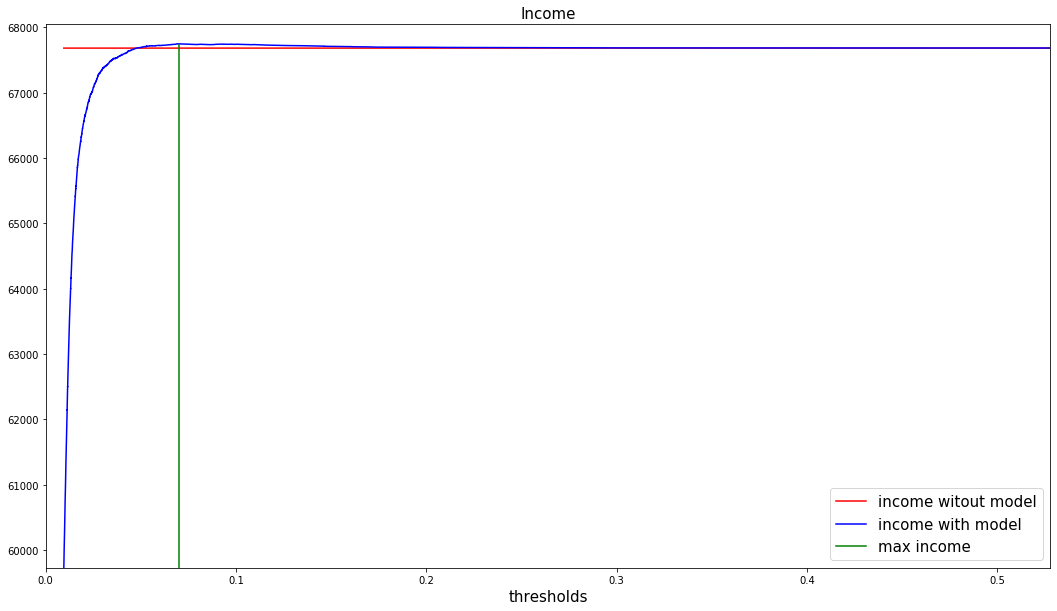

In [132]:
plt.figure(figsize = (18, 10))

plt.plot(thresholds[9000:], [income_without_model for i in thresholds[9000:]], 
                                        color = 'red', label = 'income witout model')
plt.plot(thresholds[9000:], income, color = 'blue', label = 'income with model')

thresholds_max_income = thresholds[9000 + income.index(max(income))]
y_for_max_income = [i for i in range(int(min(income)), int(max(income)), 1000)]

plt.plot([thresholds_max_income for i in y_for_max_income], y_for_max_income, color = 'green', label = 'max income')

plt.xlim(0, thresholds[-1])
plt.ylim(min(income), max(income) + 300)
plt.xlabel('thresholds', size = 15)
plt.title('Income', size = 15)
plt.legend(prop = {'size': 15})
plt.show()

Удалось подобрать порог разделения для прибыльной кампании по удержанию. Теперь имеем:

In [128]:
print('Доход без использования модели:  {} условных единиц'.format(income_without_model))
print('Доход с использованием модели:  {} условных единиц'.format(max(income)))

Доход без использования модели:  67680 условных единиц
Доход с использованием модели:  67746.0 условных единиц


Имеем прибыль от данной кампании по удержанию в размере 66 условных единиц. Данную прибыль нельзя назвать существенной.

Теперь посмотрим на результаты классификации с выбранным порогом, при котором есть прибыль: 

In [137]:
def confusion_matrix(thresholds):
    predict = []
    for probability in model.predict_proba(data_train_catboost)[:, 1]:
        if probability >= thresholds:
            predict.append(1)
        else:
            predict.append(-1)
    
    true_positive = 0
    false_positive = 0 
    false_negative = 0
    true_negative = 0
    
    for i, value in enumerate(np.array(predict)):
        if value == 1 and y_train[i] == 1:
            true_positive += 1
        if value == 1 and y_train[i] == -1:
            false_positive += 1
        if value == -1 and y_train[i] == 1:
            false_negative += 1
        if value == -1 and y_train[i] == -1:
            true_negative += 1
    
    data_churn = pd.DataFrame(columns = ['Отток', 'Не отток'], 
                              index = ['a(x) = 1', 'a(x) = -1'],
                              data = [[true_positive, false_positive], 
                                      [false_negative, true_negative]])
    return data_churn

In [143]:
s = confusion_matrix(thresholds_max_income)
s

,Отток,Не отток
a(x) = 1,60,12
a(x) = -1,1042,13524


Наша модель совершает огромное количесво ложных пропусков. Она верно определяет только 5.75 % объектов класса "отток".
<br>
Но именно такая модель с таким порогом разделения на классы дает хоть какую-то прибыль от проведения кампании по удержанию.

#### Изменение исходных параметров экономической модели

In [162]:
print('Текущий доход с использованием модели:  {} условных единиц'.format(max(income)))

Текущий доход с использованием модели:  67746.0 условных единиц


In [167]:
print('Увеличение вероятности согласия на предложение об удержании дает прибыль:  {} условных единиц'\
                                                                             .format(income_with_model(14298, 14299, 
                                                                                     income_one_user = 5,
                                                                                     retention_costs = 2, 
                                                                                     probability_contract = 0.9
)[0]))


print('Увеличение затрат на кампанию по удержанию дает прибыль:  {} условных единиц'\
                                                                             .format(income_with_model(14298, 14299, 
                                                                                     income_one_user = 5,
                                                                                     retention_costs = 3, 
                                                                                     probability_contract = 0.7
)[0]))

Увеличение вероятности согласия на предложение об удержании дает прибыль:  67806.0 условных единиц
Увеличение затрат на кампанию по удержанию дает прибыль:  67674.0 условных единиц


При увеличении вероятности согласия пользователя на предложение по удержанию имеет увеличение дохода.
<br>
При увеличении затрат на кампанию по удержанию имеем уменьшение дохода.

**Дальнейшие эксперименты** с экономической моделью, ее усложнее или изменение текущих параметров, не будут нести никакой информации о влиянии качества внедрения нашего классификатора. Они будут лишь показывать насколько прибыльна или убыточна та или иная экономическая модель. Это не даст нам никакой дополнительной информации для оценки потенциального экономического эффекта от внедрения полученного решения.

Из рассуждений, представленных выше, можно заключить, что внедрения нашего классификатора далеко не всегда экономически оправданно. Примером могут служить изменения  исходных параметров экономической модели, представленные выше.

При **увеличении качества классификатора** невозможно сделать вывод об изменении экономического эффекта от проведения кампании по удержанию. Ведь классификатор построен и максимизирован по метрике ROC-AUC, а увеличение ее значения может не дать уменьшения ложных пропусков, которых классификатор совершает огромное количество и которые сильно уменьшают итоговый доход, а только лишь может дать увеличение уверенности классификатора, при отнесении объектов к разным классам.

Хоть нам и удалось получить небольшую прибыль при внедрение классификатора, все же это сложно назвать это экономически выгодным. 
<br>
Для **увеления прибыли** от внедрения решения необходимо провести работу с классификатором. А именно уменьшить огромное количество ложных пропусков, при которых классификатор относит объекты истинного класса "отток" к классу "не отток". Это достаточно сильно уменьшает прибыль и делает внедрение решения экономически невыгодным.